In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [3]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())
    df['node_from'] = df['cc_num'].astype(str)
    df['node_to'] = df['merchant'].astype(str)
    df = df.sort_values(by=['node_from'])
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()
    return df, node_list

In [4]:
# Step 2: Create Graph Data Without torch_geometric
def create_graph_data(df, node_list):
    node_map = {node: idx for idx, node in enumerate(node_list)}
    edge_index = np.array([[node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])], dtype=np.int64).T
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)
    return node_features, edge_index, labels

In [5]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [6]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [7]:
# Function to plot class distribution
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

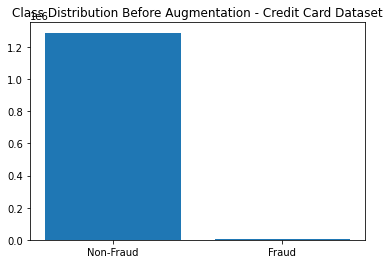

In [8]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation - Credit Card Dataset")

In [9]:
# Define GAN Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [11]:
# GAN parameters
input_size = node_features.shape[1]
hidden_size = 128
output_size = input_size
latent_size = 64

In [12]:
# Initialize GAN components
generator = Generator(latent_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)

In [13]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [14]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [15]:
# Balance Dataset with GAN
num_epochs = 10
target_minority_class = torch.sum(labels == 0)
real_data = node_features[labels == 1]

In [16]:
# GAN Training Loop
for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Generate fake data
    z = torch.randn(real_data.size(0), latent_size)
    fake_data = generator(z)
    
    # Train Discriminator
    optimizer_d.zero_grad()
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())  # Detach fake data when training discriminator
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    d_fake = discriminator(fake_data)  # Don't detach here - we want gradients to flow to generator
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    loss_g.backward()
    optimizer_g.step()

    # Add generated samples to dataset
    with torch.no_grad():
        labels = torch.cat((labels, torch.ones(fake_data.size(0), dtype=torch.long)))  # Changed to ones since these are fraud cases
        node_features = torch.cat((node_features, fake_data))

    if epoch % 2 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}')


Epoch [0/10], D Loss: 0.7390, G Loss: 0.7194
Epoch [2/10], D Loss: 0.6975, G Loss: 0.7195
Epoch [4/10], D Loss: 0.6787, G Loss: 0.7257
Epoch [6/10], D Loss: 0.6650, G Loss: 0.7368
Epoch [8/10], D Loss: 0.6513, G Loss: 0.7510


In [17]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))  # Generate samples
y_generated = torch.ones(num_generated_samples, dtype=torch.long)  # Label these as fraudulent (minority class)

In [18]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

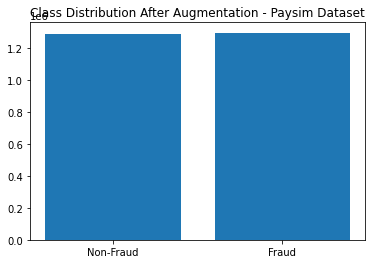

In [19]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation - Paysim Dataset")

In [20]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([1.9270e-01, 3.4059e+00, 2.2357e+02, 1.3626e+01],
       grad_fn=<MeanBackward1>), Final Variance: tensor([3.7733e-02, 1.5691e+01, 8.2968e+04, 2.7433e+02],
       grad_fn=<VarBackward0>), Final Std Dev: tensor([1.9425e-01, 3.9612e+00, 2.8804e+02, 1.6563e+01],
       grad_fn=<StdBackward0>)


In [21]:
# Assuming real_data is your actual node features labeled as fraud (real minority class)
real_data = node_features[labels == 1]  # Take only fraud samples (minority class)

# If generated_data has more samples than real_data, we need to match their size
min_size = min(real_data.size(0), generated_data.size(0))

# Subsample real and generated data to have the same number of rows
real_data_sampled = real_data[:min_size]
generated_data_sampled = generated_data[:min_size]

# Function to compute R-squared
def r_squared(real_data, generated_data):
    ss_res = torch.sum((real_data - generated_data) ** 2, dim=0)  # Residual sum of squares
    ss_tot = torch.sum((real_data - torch.mean(real_data, dim=0)) ** 2, dim=0)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [22]:
# Compute R-squared between the real and generated data samples
r2_scores = r_squared(real_data_sampled, generated_data_sampled)
print(f"R-squared for each feature: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean()}")

R-squared for each feature: tensor([-0.1591, -0.0697, -0.0722, -0.0776], grad_fn=<RsubBackward1>)
Mean R-squared: -0.09465202689170837


In [23]:
# Split Data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

In [24]:
# Define Classifier Model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [25]:
# Training Classifier on Balanced Dataset
classifier = Classifier(input_size, hidden_size)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [26]:
# Classifier Training Loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(30):
    # Training phase
    classifier.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = classifier(x_train)
    loss = loss_fn(y_pred, y_train)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Record training metrics
    train_losses.append(loss.item())
    
    # Computing training accuracy
    with torch.no_grad():
        train_accuracy = accuracy_score(y_train.cpu().numpy(), y_pred.argmax(dim=1).cpu().numpy())
        train_accuracies.append(train_accuracy)
    
    # Evaluation phase
    classifier.eval()
    with torch.no_grad():
        y_test_pred = classifier(x_test)
        test_loss = loss_fn(y_test_pred, y_test)
        test_losses.append(test_loss.item())
        test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred.argmax(dim=1).cpu().numpy())
        test_accuracies.append(test_accuracy)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

Epoch 0, Train Loss: 3.3755, Test Loss: 0.1117, Train Acc: 0.2193, Test Acc: 0.9942
Epoch 5, Train Loss: 0.2507, Test Loss: 0.2813, Train Acc: 0.9945, Test Acc: 0.9945
Epoch 10, Train Loss: 0.3391, Test Loss: 0.3605, Train Acc: 0.9945, Test Acc: 0.9945
Epoch 15, Train Loss: 0.3836, Test Loss: 0.4005, Train Acc: 0.9945, Test Acc: 0.9945
Epoch 20, Train Loss: 0.4047, Test Loss: 0.4188, Train Acc: 0.9945, Test Acc: 0.9945
Epoch 25, Train Loss: 0.4115, Test Loss: 0.4237, Train Acc: 0.9945, Test Acc: 0.9945


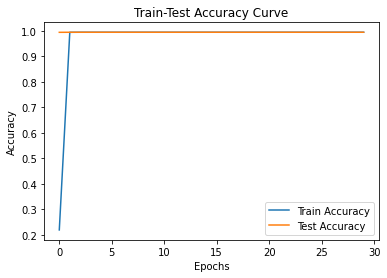

In [27]:
# Plot Train-Test Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train-Test Accuracy Curve")
plt.show()

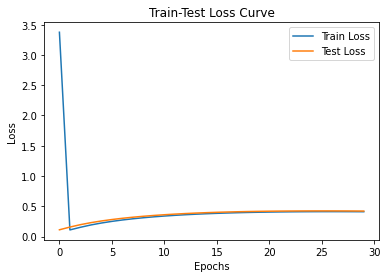

In [28]:
# Plot Train-Test Loss Curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train-Test Loss Curve")
plt.show()

In [29]:
# Compute Confusion Matrix and ROC-AUC
y_test_pred = classifier(x_test).argmax(dim=1)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[257628      0]
 [  1517  15202]]


In [30]:
# Compute ROC AUC Score
with torch.no_grad():  # Ensure gradients are not being tracked
    y_test_proba = torch.softmax(classifier(x_test), dim=1)[:, 1].detach().numpy()
    roc_auc = roc_auc_score(y_test.numpy(), y_test_proba)
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_test_proba)


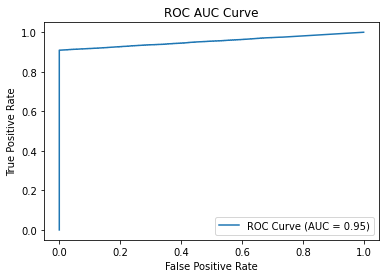

In [31]:
# Plot ROC AUC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC AUC Curve")
plt.show()